In [1]:
##--- Cell 1: Imports ---
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# --- Cell 2: Define Cleaning Function ---
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)    # Remove URLs
    text = re.sub(r'@\w+', '', text)       # Remove mentions
    text = re.sub(r'#\w+', '', text)       # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove punctuation and numbers
    text = text.lower()                   # Convert to lowercase
    
    words = text.split()
    cleaned_words = [ps.stem(word) for word in words if word not in stop_words]
    
    return " ".join(cleaned_words)

In [3]:
# --- Cell 3: Load and Prepare Data ---
from pathlib import Path

# Try to locate the CSV file in the current directory or inside a 'tweets.csv' folder.
# The original string 'tweets.csv\training.1600000.processed.noemoticon.csv' caused an invalid path.
csv_candidates = [
	Path('training.1600000.processed.noemoticon.csv'),
	Path('tweets.csv') / 'training.1600000.processed.noemoticon.csv',
	Path('tweets.csv')
]

csv_path = None
for p in csv_candidates:
	if p.exists() and p.is_file():
		csv_path = p
		break

# If not found, search recursively for the filename
if csv_path is None:
	matches = list(Path('.').rglob('training.1600000.processed.noemoticon.csv'))
	if matches:
		csv_path = matches[0]
if csv_path is None:
	raise FileNotFoundError("Could not find 'training.1600000.processed.noemoticon.csv' in the current directory or a 'tweets.csv' folder. Place the CSV in the notebook folder or update the path.")

# Load your dataset
df = pd.read_csv(csv_path, encoding='latin-1', header=None)

# Rename columns (assuming 0=sentiment, 5=text)
df = df[[5, 0]]
df.columns = ['text', 'sentiment']

# Map sentiment labels
df['sentiment'] = df['sentiment'].map({0: 'Negative', 4: 'Positive'})
df = df.dropna()

In [4]:
# --- Cell 4: Apply Cleaning ---
print("Cleaning text data...")
df['cleaned_text'] = df['text'].apply(clean_tweet)

Cleaning text data...


In [5]:
# --- Cell 5: Label Encoding ---
df['label'] = df['sentiment'].map({'Positive': 1, 'Negative': 0})

Displaying Sentiment Distribution...


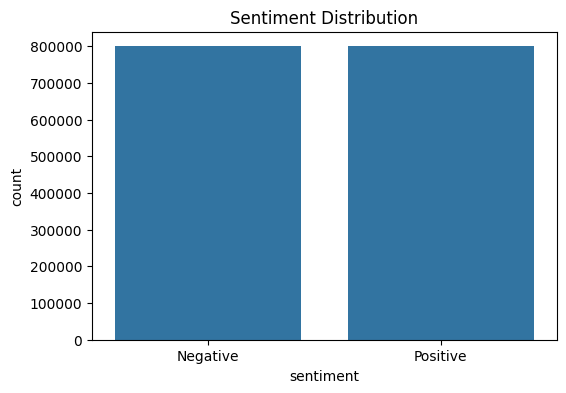

Generating Positive Word Cloud...


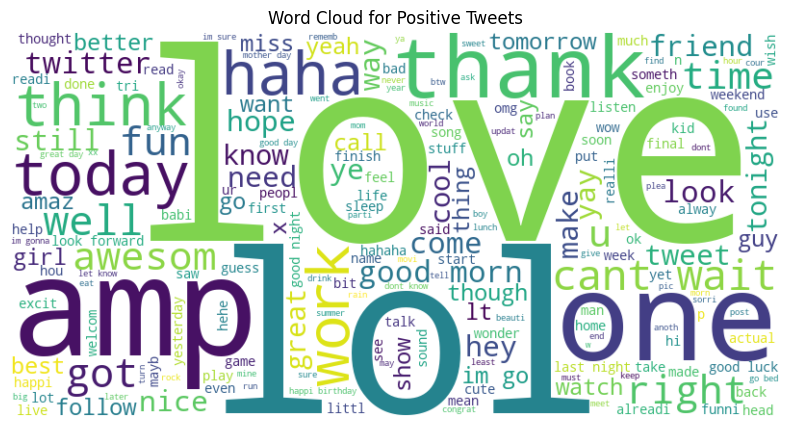

Generating Negative Word Cloud...


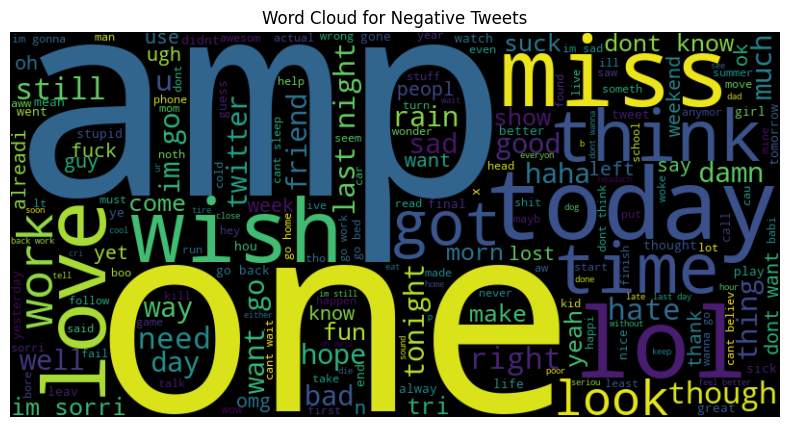

In [6]:
# --- Cell 6: Data Visualization (Recommended Charts) ---

# Chart 1: Sentiment Distribution
print("Displaying Sentiment Distribution...")
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

# Chart 2: Word Cloud for Positive Tweets
print("Generating Positive Word Cloud...")
positive_tweets = " ".join(df[df['sentiment'] == 'Positive']['cleaned_text'])
pos_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Tweets')
plt.axis('off')
plt.show()

# Chart 3: Word Cloud for Negative Tweets
print("Generating Negative Word Cloud...")

# Filter for 'Negative' sentiment
negative_tweets = " ".join(df[df['sentiment'] == 'Negative']['cleaned_text'])

# Create the WordCloud object (using a black background for contrast)
neg_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_tweets)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Tweets')
plt.axis('off')
plt.show()

In [7]:
# --- Cell 7: Segregate X and Y ---
X = df['cleaned_text']
Y = df['label']

In [8]:
# --- Cell 8: TF-IDF Vectorization (Feature Transformation) ---
print("Vectorizing text...")
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

Vectorizing text...


In [9]:
# --- Cell 9: Train-Test Split ---
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)

In [10]:
# --- Cell 9: Train-Test Split ---
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)

In [11]:
# --- Cell 10: Train Model ---
print("Training model...")
model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
model.fit(X_train, Y_train)

Training model...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
# --- Cell 11: Evaluate Model ---
test_preds = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(Y_test, test_preds) * 100:.2f}%")

Model Accuracy: 77.14%


--- Comprehensive Model Performance Metrics ---
Accuracy:  77.14%
Precision: 76.14%
Recall:    79.25%
F1-Score:  77.66%

--- Detailed Classification Report ---
              precision    recall  f1-score   support

    Negative       0.78      0.75      0.77    159494
    Positive       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000


--- Confusion Matrix Visualization ---


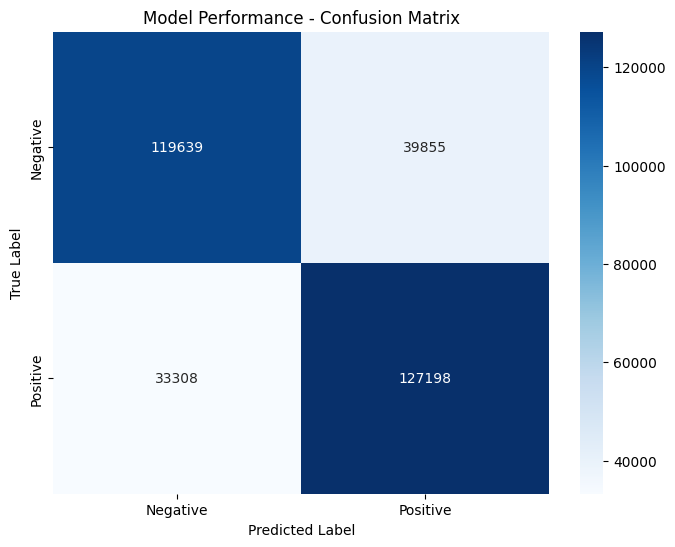

In [13]:
# --- New Cell: Comprehensive Model Evaluation ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Ensure you have Y_test (true labels) and test_preds (model predictions)
# from previous cells (Cell 9 and Cell 11)

print("--- Comprehensive Model Performance Metrics ---")

# 1. Calculate individual metrics
#    Note: 'pos_label=1' assumes 1 is your 'Positive' class (as per your mapping)
accuracy = accuracy_score(Y_test, test_preds)
precision = precision_score(Y_test, test_preds, pos_label=1)
recall = recall_score(Y_test, test_preds, pos_label=1)
f1 = f1_score(Y_test, test_preds, pos_label=1)

print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1-Score:  {f1 * 100:.2f}%")

# 2. Display the Classification Report
#    This provides precision, recall, f1-score, and support for both classes (Negative and Positive)
print("\n--- Detailed Classification Report ---")
# target_names should match your actual class labels (0: Negative, 1: Positive)
print(classification_report(Y_test, test_preds, target_names=['Negative', 'Positive']))


# 3. Plot the Confusion Matrix
print("\n--- Confusion Matrix Visualization ---")
cm = confusion_matrix(Y_test, test_preds)

plt.figure(figsize=(8, 6)) # Adjust figure size for better readability
sns.heatmap(cm,
            annot=True,     # Show the numbers in each cell
            fmt='d',        # Format as integers (for counts)
            cmap='Blues',   # Color theme (e.g., 'Blues', 'Greens', 'YlGnBu')
            xticklabels=['Negative', 'Positive'], # Labels for predicted classes
            yticklabels=['Negative', 'Positive']) # Labels for true classes

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Model Performance - Confusion Matrix')
plt.show()

In [14]:
# --- Cell 12: Save Model and Vectorizer ---
# This is the most important part for your Flask app!
print("Saving model and vectorizer to .pkl files...")

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("--- Model training complete. Files saved. ---")

Saving model and vectorizer to .pkl files...
--- Model training complete. Files saved. ---
